# **Reproducing DeepDTA**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import numpy as np
import csv
import random
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers

In [3]:
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

In [4]:
# load data
df = pd.read_csv("/content/drive/MyDrive/Project_Monday/finalized_dataset.csv")
df.head()

,Smiles_nostereo,poi_seq,e3_ligase_seq,active
0,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(C...,MGKKHKKHKAEWRSSYEDYADKPLEKPLKLVLKVGGSEVTELSGSG...,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,0
1,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(C...,MGKKHKKHKAEWRSSYEDYADKPLEKPLKLVLKVGGSEVTELSGSG...,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,1
2,COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(C...,MGKKHKKHKSDKHLYEEYVEKPLKLVLKVGGNEVTELSTGSSGHDS...,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,1
3,CCN(CCCCCOCC(=O)NC(C(=O)N1CC(O)CC1C(=O)NC(C)c1...,MTMTLHTKASGMALLHQIQGNELEPLNRPQLKIPLERPLGEVYLDS...,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,1
4,CCN(CCCCCOCC(=O)NC(C(=O)N1CC(O)CC1C(=O)NC(C)c1...,MTMTLHTKASGMALLHQIQGNELEPLNRPQLKIPLERPLGEVYLDS...,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,1


In [5]:
df.columns

Index(['Smiles_nostereo', 'poi_seq', 'e3_ligase_seq', 'active'], dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 822 entries, 0 to 821
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Smiles_nostereo  822 non-null    object
 1   poi_seq          822 non-null    object
 2   e3_ligase_seq    822 non-null    object
 3   active           822 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 25.8+ KB


In [7]:
# df2 = df.drop(columns=['ligand_id', 'prot_id'], axis = 1)

In [8]:
# df2

In [9]:
df.isna().sum()

Smiles_nostereo    0
poi_seq            0
e3_ligase_seq      0
active             0
dtype: int64

In [10]:
# df2.dropna(subset = ['affinity_score'], axis = 0, inplace = True)

In [11]:
type(df)

pandas.core.frame.DataFrame

In [12]:
# Extracting columns into separate lists
smiles_list = df['Smiles_nostereo'].tolist()
poi_seq_list = df['poi_seq'].tolist()
e3_lig_seq_list = df['e3_ligase_seq'].tolist()
label = df['active'].tolist()

In [13]:
# Initialize variable to store the length of the longest SMILES sequence
max_length = 0

# Iterate over each SMILES sequence in the list
for smiles in smiles_list:
    # Calculate the length of the current SMILES sequence
    current_length = len(smiles)

    # Update max_length if the current length is greater
    if current_length > max_length:
        max_length = current_length

# Print the length of the longest SMILES sequence
print("Length of the longest SMILES sequence:", max_length)

Length of the longest SMILES sequence: 203


In [14]:
# Initialize variable to store the length of the longest SMILES sequence
max_length = 0

# Iterate over each SMILES sequence in the list
for seq in poi_seq_list:
    # Calculate the length of the current SMILES sequence
    current_length = len(seq)

    # Update max_length if the current length is greater
    if current_length > max_length:
        max_length = current_length

# Print the length of the longest SMILES sequence
print("Length of the longest POI sequence:", max_length)

Length of the longest POI sequence: 1647


In [15]:
# Initialize variable to store the length of the longest SMILES sequence
max_length = 0

# Iterate over each SMILES sequence in the list
for e3_seq in e3_lig_seq_list:
    # Calculate the length of the current SMILES sequence
    current_length = len(e3_seq)

    # Update max_length if the current length is greater
    if current_length > max_length:
        max_length = current_length

# Print the length of the longest SMILES sequence
print("Length of the longest E3 ligase sequence:", max_length)

Length of the longest E3 ligase sequence: 1538


In [16]:
smiles_list[0]

'COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(CCOCCOCCOc2cc(-c3scnc3C)ccc2CNC(=O)C2CC(O)CN2C(=O)C(NC(=O)C2(F)CC2)C(C)(C)C)CC1'

In [17]:
len(smiles_list[0])

124

In [18]:
poi_seq_list[0]

'MGKKHKKHKAEWRSSYEDYADKPLEKPLKLVLKVGGSEVTELSGSGHDSSYYDDRSDHERERHKEKKKKKKKKSEKEKHLDDEERRKRKEEKKRKREREHCDTEGEADDFDPGKKVEVEPPPDRPVRACRTQPAENESTPIQQLLEHFLRQLQRKDPHGFFAFPVTDAIAPGYSMIIKHPMDFGTMKDKIVANEYKSVTEFKADFKLMCDNAMTYNRPDTVYYKLAKKILHAGFKMMSKQAALLGNEDTAVEEPVPEVVPVQVETAKKSKKPSREVISCMFEPEGNACSLTDSTAEEHVLALVEHAADEARDRINRFLPGGKMGYLKRNGDGSLLYSVVNTAEPDADEEETHPVDLSSLSSKLLPGFTTLGFKDERRNKVTFLSSATTALSMQNNSVFGDLKSDEMELLYSAYGDETGVQCALSLQEFVKDAGSYSKKVVDDLLDQITGGDHSRTLFQLKQRRNVPMKPPDEAKVGDTLGDSSSSVLEFMSMKSYPDVSVDISMLSSLGKVKKELDPDDSHLNLDETTKLLQDLHEAQAERGGSRPSSNLSSLSNASERDQHHLGSPSRLSVGEQPDVTHDPYEFLQSPEPAASAKT'

In [19]:
len(poi_seq_list[0])

597

In [20]:
e3_lig_seq_list[0]

'MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPEELGAEEEMEAGRPRPVLRSVNSREPSQVIFCNRSPRVVLPVWLNFDGEPQPYPTLPPGTGRRIHSYRGHLWLFRDAGTHDGLLVNQTELFVPSLNVDGQPIFANITLPVYTLKERCLQVVRSLVKPENYRRLDIVRSLYEDLEDHPNVQKDLERLTQERIAHQRMGD'

In [21]:
len(e3_lig_seq_list[0])

213

### **Train_Test_split**

In [22]:
split = int(0.8 * len(smiles_list))

train_smiles = smiles_list[:split]
test_smiles = smiles_list[split:]

train_poi_seq = poi_seq_list[:split]
test_poi_seq = poi_seq_list[split:]

train_e3_lig = e3_lig_seq_list[:split]
test_e3_lig = e3_lig_seq_list[split:]

train_labels = label[:split]
test_labels = label[split:]

In [23]:
len(train_smiles), len(train_poi_seq), len(train_e3_lig), len(train_labels)

(657, 657, 657, 657)

### Our input data is in form of strings so we need to encode them

In [24]:
# Tokenize smiles

# train (this set is performed on only training data, never on test data)
tokenizer_smiles = Tokenizer(char_level = True)
tokenizer_smiles.fit_on_texts(train_smiles)

# word index is just a dictionary that shows us what index corresponds to what character
word_index_smiles = tokenizer_smiles.word_index
vocab_size_smiles = len(word_index_smiles)

#every drug in our dataset is converted into sequence of numbers
train_sequences_smiles = tokenizer_smiles.texts_to_sequences(train_smiles)
'''Every smile file has not the same length, but our neural network expects a
fixed length input so to do that we use padding layers.
`maxlen =85` means the maximum length of input sequence, it is 85 because authors of papaer have stated it. '''
train_padded_smiles = pad_sequences(train_sequences_smiles, truncating = 'post', padding = 'post', maxlen = 203)


#test
test_sequences_smiles = tokenizer_smiles.texts_to_sequences(test_smiles)
test_padded_smiles = pad_sequences(test_sequences_smiles, truncating = 'post', padding = 'post', maxlen = 203)

In [25]:
# Tokenize POI sequence

#train
tokenizer_poi = Tokenizer(char_level = True)
tokenizer_poi.fit_on_texts(train_poi_seq)

word_index_poi = tokenizer_poi.word_index
vocab_size_poi = len(word_index_poi)

train_sequences_poi = tokenizer_poi.texts_to_sequences(train_poi_seq)
train_padded_poi = pad_sequences(train_sequences_poi, truncating  = 'post', padding = 'post', maxlen = 1647)

#test
test_sequences_poi = tokenizer_poi.texts_to_sequences(test_poi_seq)
test_padded_poi = pad_sequences(test_sequences_poi, truncating = 'post', padding = 'post', maxlen = 1647)


In [26]:
# Tokenize E3 ligase sequence

#train
tokenizer_e3 = Tokenizer(char_level = True)
tokenizer_e3.fit_on_texts(train_e3_lig)

word_index_e3 = tokenizer_e3.word_index
vocab_size_e3 = len(word_index_e3)

train_sequences_e3 = tokenizer_e3.texts_to_sequences(train_e3_lig)
train_padded_e3 = pad_sequences(train_sequences_e3, truncating  = 'post', padding = 'post', maxlen = 1538)

#test
test_sequences_e3 = tokenizer_poi.texts_to_sequences(test_e3_lig)
test_padded_e3 = pad_sequences(test_sequences_e3, truncating = 'post', padding = 'post', maxlen = 1538)

In [59]:
print(vocab_size_smiles)
print(vocab_size_poi)
print(vocab_size_e3)

26
22
20


In [28]:
# convert to numpy arrays and check dimensions
train_smiles_array = np.array(train_padded_smiles)
test_smiles_array = np.array(test_padded_smiles)

train_poi_array = np.array(train_padded_poi)
test_poi_array = np.array(test_padded_poi)

train_e3_array = np.array(train_padded_e3)
test_e3_array = np.array(test_padded_e3)

train_labels_array = np.array(train_labels, dtype = 'int64')
test_labels_array = np.array(test_labels, dtype = 'int64')

print(f"Train smiles array shape: {train_smiles_array.shape}")
print(f"Test smile array shape: {test_smiles_array.shape}")

print(f" Train POI array shape: {train_poi_array.shape}")
print(f"Test POI array shape: {test_poi_array.shape}")

print(f"Train e3 array shape: {train_e3_array.shape}")
print(f"Test e3 array shape: {test_e3_array.shape}")


print(f"Train labels array shape: {train_labels_array.shape}")
print(f"Test labels array shape: {test_labels_array.shape}")

Train smiles array shape: (657, 203)
Test smile array shape: (165, 203)
 Train POI array shape: (657, 1647)
Test POI array shape: (165, 1647)
Train e3 array shape: (657, 1538)
Test e3 array shape: (165, 1538)
Train labels array shape: (657,)
Test labels array shape: (165,)


In [ ]:
# aaddressing class imabalnce problem
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(train_labels_array), y=train_labels_array)

# Convert to dictionary
class_weight_dict = dict(enumerate(class_weights))

# **Deep DTA Model**

In [42]:
from keras.layers import Input, Embedding, Concatenate, Conv1D, GlobalMaxPooling1D, Dense, Dropout, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Define three input layers i.e one for smile sequence and one for protein
smile_input = Input((203,))
protein_input = Input((1647,))
e3_input = Input((1538))

#smiles encoder
embed_smiles = Embedding(vocab_size_smiles+1, 128, input_length=203)(smile_input)
conv_smiles = Conv1D(32, 4, activation='relu')(embed_smiles)
conv_smiles = Conv1D(64, 6, activation='relu')(conv_smiles)
conv_smiles = Conv1D(96, 8, activation='relu')(conv_smiles)
max_smiles = GlobalMaxPooling1D()(conv_smiles)

#proteins encoder
embed_protein = Embedding(vocab_size_poi+1, 128, input_length=1647)(protein_input)
conv_protein = Conv1D(32, 4, activation="relu")(embed_protein)
conv_protein = Conv1D(64, 8, activation="relu")(conv_protein)
conv_protein = Conv1D(96, 12, activation="relu")(conv_protein)
max_protein = GlobalMaxPooling1D()(conv_protein)

# E3 encoder
embed_e3 = Embedding(vocab_size_e3+1, 128, input_length=1538)(e3_input)
conv_e3 = Conv1D(32, 4, activation="relu")(embed_e3)
conv_e3 = Conv1D(64, 8, activation="relu")(conv_e3)
conv_e3 = Conv1D(96, 12, activation="relu")(conv_e3)
max_e3 = GlobalMaxPooling1D()(conv_e3)


# concatenate the two encoder outputs
concat_layer = Concatenate()([max_smiles, max_protein, max_e3])

# decoder
output = Dense(2048, activation="relu")(concat_layer)
output = Dropout(0.5)(output)
output = Dense(1024, activation="relu")(output)  # Modified
output = Dropout(0.5)(output)
output = Dense(512, activation="relu")(output)   # Modified
output = Dropout(0.5)(output)
output = Dense(1, activation="sigmoid")(output)


# define model with a list of 3 inputs
model = Model(inputs=[smile_input, protein_input, e3_input], outputs=output)



# Compile model
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train model
history = model.fit([train_smiles_array, train_poi_array, train_e3_array], train_labels_array,
                    validation_data=([test_smiles_array, test_poi_array, test_e3_array], test_labels_array),
                    epochs=100, batch_size=32, callbacks=[early_stopping], class_weight=class_weight_dict)

# Evaluate model
loss, mse = model.evaluate([test_smiles_array, test_poi_array, test_e3_array], test_labels_array)
print("Test MSE:", mse)


Epoch 1/100
21/21 [==============================] - 6s 70ms/step - loss: 0.7027 - accuracy: 0.5479 - val_loss: 0.7003 - val_accuracy: 0.4182
Epoch 2/100
21/21 [==============================] - 1s 41ms/step - loss: 0.6821 - accuracy: 0.3409 - val_loss: 0.6947 - val_accuracy: 0.5091
Epoch 3/100
21/21 [==============================] - 1s 45ms/step - loss: 0.6702 - accuracy: 0.6834 - val_loss: 0.6981 - val_accuracy: 0.5879
Epoch 4/100
21/21 [==============================] - 1s 42ms/step - loss: 0.5508 - accuracy: 0.7306 - val_loss: 0.6939 - val_accuracy: 0.5939
Epoch 5/100
21/21 [==============================] - 1s 37ms/step - loss: 0.4989 - accuracy: 0.6925 - val_loss: 0.6573 - val_accuracy: 0.6061
Epoch 6/100
21/21 [==============================] - 1s 39ms/step - loss: 0.4878 - accuracy: 0.7017 - val_loss: 0.6904 - val_accuracy: 0.5697
Epoch 7/100
21/21 [==============================] - 1s 39ms/step - loss: 0.4992 - accuracy: 0.6743 - val_loss: 0.6970 - val_accuracy: 0.5636
Epoch 

In [43]:
def evaluate_model(model, X_test_smiles, X_test_protein, X_test_e3, y_test):
    """
    Evaluate the accuracy of the model on the test set.

    Args:
    model: The trained model.
    X_test_smiles: Test data for SMILES sequences.
    X_test_protein: Test data for protein sequences.
    y_test: True labels for the test set.

    Returns:
    accuracy: Accuracy of the model on the test set.
    """

    # Predict labels for the test set
    y_pred = model.predict([X_test_smiles, X_test_protein, X_test_e3])

    # Evaluate accuracy
    accuracy = model.evaluate([X_test_smiles, X_test_protein, X_test_e3], y_test, verbose=0)[1]

    return accuracy


In [44]:
evaluate_model(model, test_smiles_array, test_poi_array,  test_e3_array, test_labels_array)

6/6 [==============================] - 0s 14ms/step


0.6060606241226196

<Figure size 640x480 with 0 Axes>

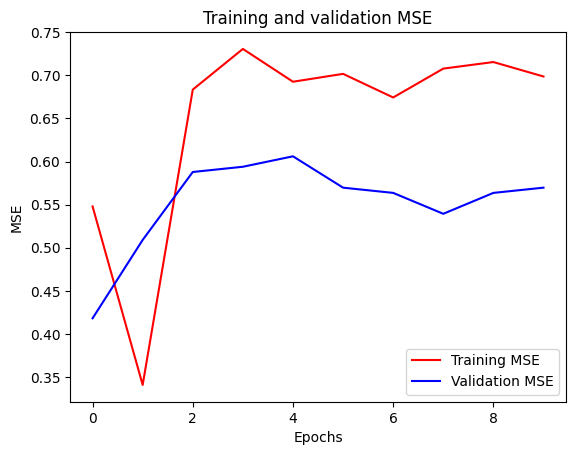

<Figure size 640x480 with 0 Axes>

In [45]:
import matplotlib.pyplot as plt

#---------------------------------------------------------------
# Retrieve a list of list results on training and test data
#Sets for each training epoch
#---------------------------------------------------------------
mse = history.history['accuracy']
val_mse = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(mse)) #Get number of epochs

#---------------------------------------------------------------
# Plot training and validation mse per epoch
#----------------------------------------------------------------
plt.plot(epochs, mse, 'r')
plt.plot(epochs, val_mse, 'b')
plt.title("Training and validation MSE")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend(["Training MSE", "Validation MSE"])

plt.figure()

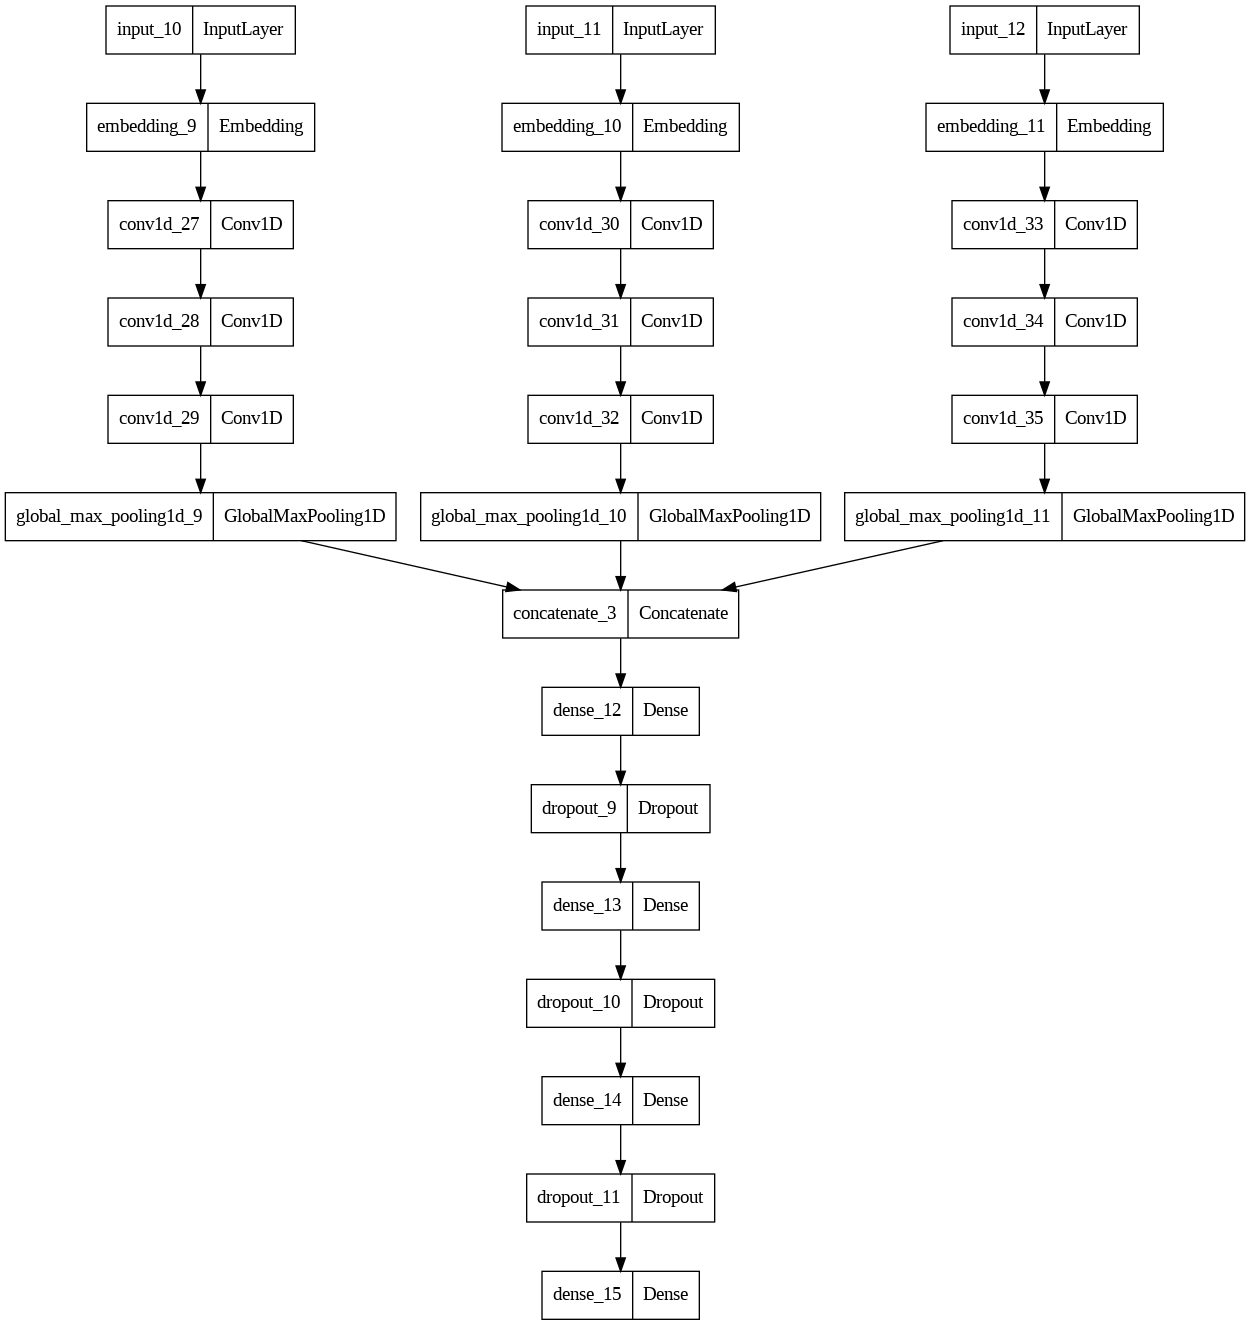

In [46]:
# visualize the model
tf.keras.utils.plot_model(model)

In [47]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 203)]                0         []                            
                                                                                                  
 input_11 (InputLayer)       [(None, 1647)]               0         []                            
                                                                                                  
 input_12 (InputLayer)       [(None, 1538)]               0         []                            
                                                                                                  
 embedding_9 (Embedding)     (None, 203, 128)             3456      ['input_10[0][0]']            
                                                                                            

In [48]:
model.save("model1.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [55]:
from keras.layers import Input, Embedding, Concatenate, Conv1D, GlobalMaxPooling1D, Dense, Dropout, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters


# Define model-building function
def build_model(hp):
    # Define input layers
    smile_input = Input((203,))
    protein_input = Input((1647,))
    e3_input = Input((1538,))

    # Smiles encoder
    embed_smiles = Embedding(vocab_size_smiles + 1, 128, input_length=203)(smile_input)
    conv_smiles = Conv1D(32, 4, activation='relu')(embed_smiles)
    conv_smiles = Conv1D(64, 6, activation='relu')(conv_smiles)
    conv_smiles = Conv1D(96, 8, activation='relu')(conv_smiles)
    max_smiles = GlobalMaxPooling1D()(conv_smiles)

    # Proteins encoder
    embed_protein = Embedding(vocab_size_poi + 1, 128, input_length=1647)(protein_input)
    conv_protein = Conv1D(32, 4, activation="relu")(embed_protein)
    conv_protein = Conv1D(64, 8, activation="relu")(conv_protein)
    conv_protein = Conv1D(96, 12, activation="relu")(conv_protein)
    max_protein = GlobalMaxPooling1D()(conv_protein)

    # E3 encoder
    embed_e3 = Embedding(vocab_size_e3 + 1, 128, input_length=1538)(e3_input)
    conv_e3 = Conv1D(32, 4, activation="relu")(embed_e3)
    conv_e3 = Conv1D(64, 8, activation="relu")(conv_e3)
    conv_e3 = Conv1D(96, 12, activation="relu")(conv_e3)
    max_e3 = GlobalMaxPooling1D()(conv_e3)

    # Concatenate the three encoder outputs
    concat_layer = Concatenate()([max_smiles, max_protein, max_e3])

    # Define hyperparameters to tune
    hp_units = hp.Int('units', min_value=1, max_value=1024, step=256)
    hp_dropout = hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)

    # Add dense layers with dropout
    output = Dense(hp_units, activation="relu")(concat_layer)
    output = Dropout(hp_dropout)(output)
    output = Dense(1, activation="sigmoid")(output)

    # Define model
    model = Model(inputs=[smile_input, protein_input, e3_input], outputs=output)

    # Compile model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Instantiate the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    directory='my_dir',
    project_name='my_project'
)

# Perform hyperparameter search
tuner.search([train_smiles_array, train_poi_array, train_e3_array], train_labels_array,
             validation_data=([test_smiles_array, test_poi_array, test_e3_array], test_labels_array),
             epochs=100,
             callbacks=[early_stopping])

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model
loss, accuracy = best_model.evaluate([test_smiles_array, test_poi_array, test_e3_array], test_labels_array)
print("Test Accuracy:", accuracy)

Trial 10 Complete [00h 00m 23s]
val_accuracy: 0.581818163394928

Best val_accuracy So Far: 0.6909090876579285
Total elapsed time: 00h 06m 30s
6/6 [==============================] - 0s 15ms/step - loss: 0.6367 - accuracy: 0.6909
Test Accuracy: 0.6909090876579285


In [57]:
best_model.save("model2.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<Figure size 640x480 with 0 Axes>

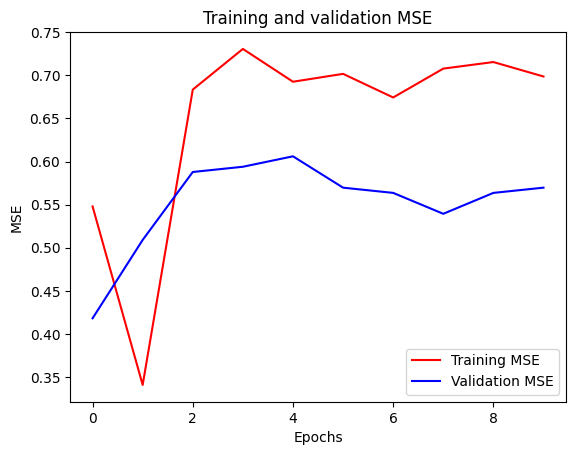

<Figure size 640x480 with 0 Axes>

In [58]:
import matplotlib.pyplot as plt

#---------------------------------------------------------------
# Retrieve a list of list results on training and test data
#Sets for each training epoch
#---------------------------------------------------------------
mse = history.history['accuracy']
val_mse = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(mse)) #Get number of epochs

#---------------------------------------------------------------
# Plot training and validation mse per epoch
#----------------------------------------------------------------
plt.plot(epochs, mse, 'r')
plt.plot(epochs, val_mse, 'b')
plt.title("Training and validation MSE")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend(["Training MSE", "Validation MSE"])

plt.figure()

# **Make predications**

In [ ]:
# # Function to predict drug-protein pKd

# def predict_pKd(drug, protein):
#     drug_sequence = tokenizer_smiles.texts_to_sequences([drug])
#     drug_padded = pad_sequences(drug_sequence, truncating= "post", padding = "post", maxlen = 85)
#     protein_sequence = tokenizer_proteins.texts_to_sequences([protein])
#     protein_padded = pad_sequences(protein_sequence, truncating = "post", padding = "post", maxlen = 1200)
#     prediction = model.predict([tf.expand_dims(drug_padded, axis = -1), tf.expand_dims(protein_padded, axis = -1)])

#     return(prediction.item())

In [ ]:
# drug = test_smiles[1]
# protein = test_proteins[1]
# label = test_labels[1]

# print(label)
# predict_pKd(drug = drug, protein = protein)

5.0
1/1 [==============================] - 0s 149ms/step


5.2772321701049805

In [ ]:
# test_labels.index(max(test_labels))

1232

In [ ]:
# # load a previously saved model
# model = tf.keras.models.load_model("reproducing_deepDTA.h5")